In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE

# Introduzione

### Caricamento dei dati e Operazioni preliminari

Carichiamo i dati dal file csv e vediamo i primi valori

In [2]:
df = pd.read_csv('water_potability.csv')

In [3]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Visualizziamo la forma dei dati per capire quante righe ci sono

In [4]:
df.shape

(3276, 10)

In [5]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


Dai dati aggregati, si nota che ci possono essere degli outlier presenti nel dataset, come nel caso della feature **solids** dove il valore massimo è ben maggiore della media + 3 deviazioni standard. Verificheremo la loro presenza in modo più dettagliato a breve.  
La media di **potability** non è 0.5 e quindi può lasciar intendere uno sbilanciamento delle classi, con una maggior presenza di 0.  
Il conteggio invece evidenzia che ci sono delle colonne (**pH**, **Sulfate**, **Trihalomethanes**) con dei valori nulli, che andranno gestiti. 

### Distribuzione delle variabili

Vediamo le variabili una per una per visualizzare la loro distribuzione.  

In [6]:
posizioni = [[i, j] for i in range(3) for j in range(3)] #crea una lista di liste che parte da [0,0] fino ad arrivare a [2,2]

dizionario = {x: posizioni[i] for i, x in enumerate(df.drop(columns='Potability'))} #crea un dizionario che assegna a ogni variabile del dataframe una posizione nel subplot di matplotlib

dizionario

{'ph': [0, 0],
 'Hardness': [0, 1],
 'Solids': [0, 2],
 'Chloramines': [1, 0],
 'Sulfate': [1, 1],
 'Conductivity': [1, 2],
 'Organic_carbon': [2, 0],
 'Trihalomethanes': [2, 1],
 'Turbidity': [2, 2]}

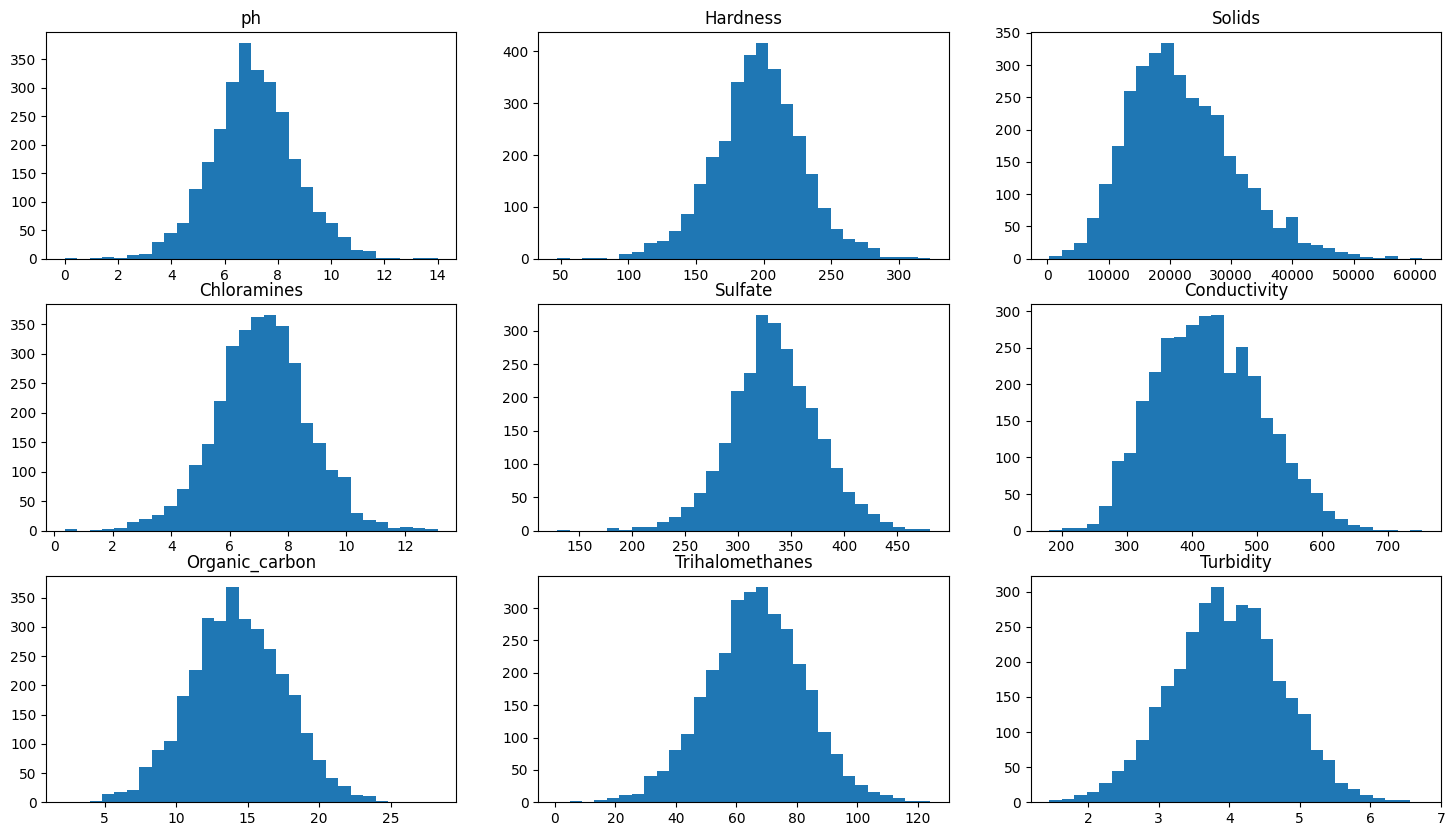

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,10))

for key in dizionario:
    i = dizionario[key][0] #la posizione sulle righe
    j = dizionario[key][1] #la posizione sulle colonne
    ax[i][j].hist(df[key], bins=30)
    ax[i][j].set_title(key)

Si vede che tutte le variabili seguono una distribuzione normale.  
**Solids** ha un'accentuata skewness positiva. 

# Pulizia dei dati

### Gestione dei dati mancanti

In [8]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Ci sono 491 dati mancanti per il **ph**, 781 per **Sulphate** e 162 per **Trihalomethanes**.  
Per riempire questi valori utilizzeremo l'algoritmo **KNNImputer**: le righe che contengono valori nulli verranno trattate come target dell'algoritmo KNN; verranno prese le *k* righe più simili e sulla base di quelle si determineranno i nuovi valori delle feature mancanti. 

In [9]:
imputer = KNNImputer() #impostiamo l'algoritmo
y = df['Potability'] #salviamo separatamente il target
f_names = df.drop(columns='Potability').columns #salviamo il nome delle colonne, perché verranno cancellate dall'algoritmo
df = imputer.fit_transform(df.drop(columns='Potability')) #non vogliamo che l'algoritmo consideri il target nel suo processo
df = pd.DataFrame(df, columns=f_names) #ricomponiamo il DataFrame
df = pd.concat([df, y], axis=1) #riconcateniamo la X con la y
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.156857,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,336.094350,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,330.449166,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


Verifichiamo che l'operazione abbia avuto successo:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               3276 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          3276 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3276 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Ora i valori nulli sono stati sostituiti in tutte le colonne. 

### Identificazione degli outliers

Vediamo graficamente se ci sono degli outliers feature per feature con dei boxplot. Le dividiamo per le due classi di Potability:

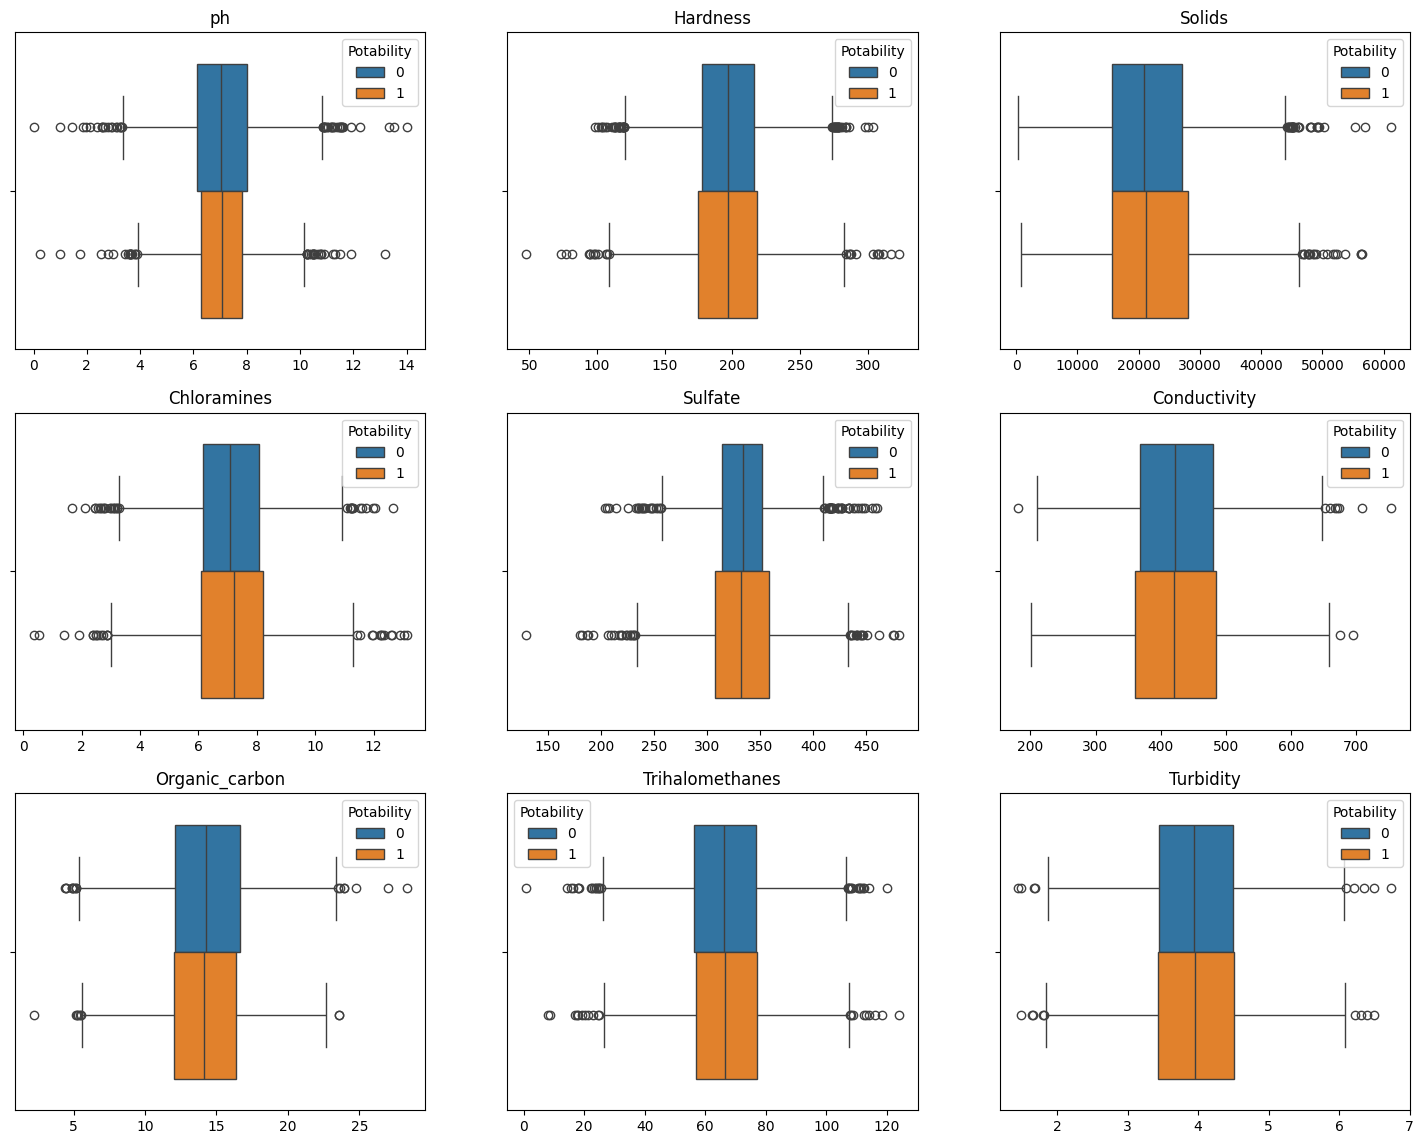

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,14))

for key in dizionario: #dizionario è una variabile definita nel capitolo 'Distribuzione delle variabili'
    i = dizionario[key][0] 
    j = dizionario[key][1] 
    sns.boxplot(df, x=df[key], hue='Potability', ax=ax[i][j])
    ax[i][j].set_xlabel("")
    ax[i][j].set_title(key)

Si conferma la presenza di alcuni outliers in ogni feature, ovvero i cerchi al di fuori del range dei whisker dei boxplot.

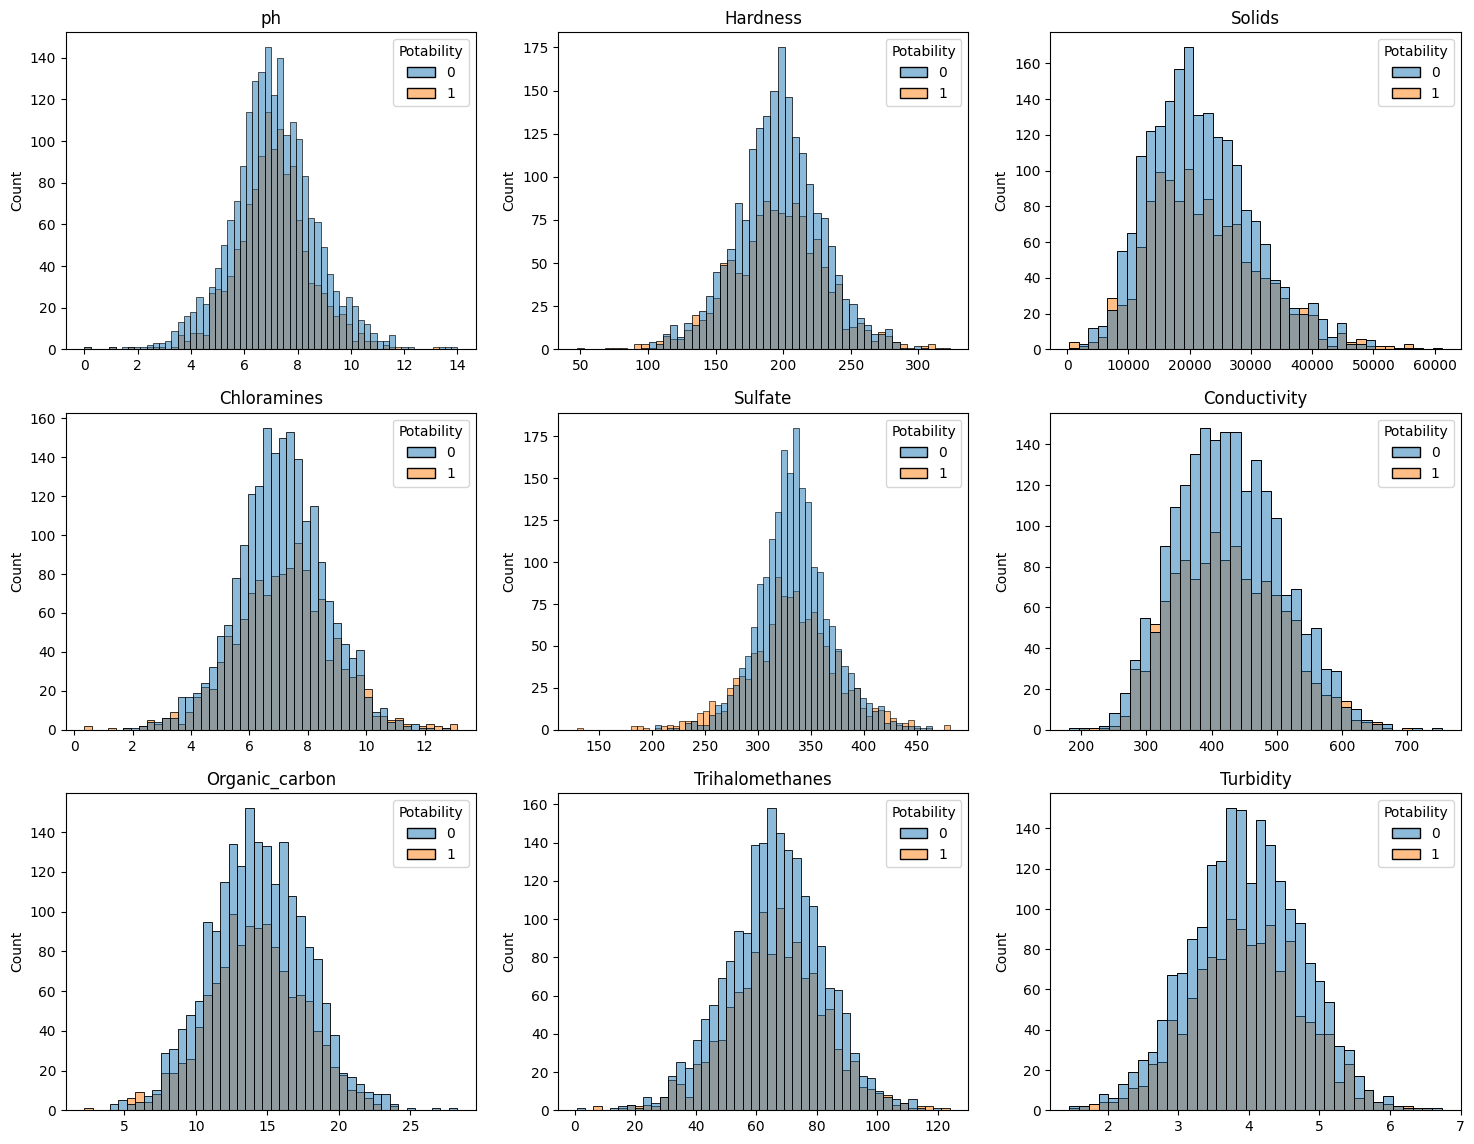

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,14))

for key in dizionario: #dizionario è una variabile definita nel capitolo 'Distribuzione delle variabili'
    i = dizionario[key][0] 
    j = dizionario[key][1] 
    sns.histplot(df, x=key, hue='Potability', ax=ax[i][j])
    ax[i][j].set_xlabel("")
    ax[i][j].set_title(key)

Tuttavia, guardando le distribuzioni si vede che questi outlier potrebbero essere semplicemente dei valori estremi naturali. Si vede ad esempio che il pH ha degli outlier a 0 e 14, ma si tratta di valori che potrebbero essere teoricamente raggiungibili dall'acqua e non sono quindi dovuti a errori di battitura o di misurazione.    
Pertanto, rimuovendoli si perderebbero importanti informazioni. Li manterremo all'interno del dataset.

### Scaling

Come si è visto nei grafici precedenti, ogni feature ha un range di distribuzione differente.  
Ciò può portare a problemi, perché alcune features potrebbero risultare più influenti di altre senza ragione.  
Per questo motivo, procederemo a svolgere uno scaling usando **StandardScaler** di Scikit-learn: a ogni dato verrà rimossa la media della feature e poi si dividerà per la deviazione standard. In questo modo, ogni feature avrà media pari a 0 e deviazione standard pari a 1. 

In [13]:
scaler = StandardScaler() #impostiamo l'algoritmo
y = df['Potability'] #salviamo separatamente il target
f_names = df.drop(columns='Potability').columns #salviamo il nome delle colonne, perché verranno cancellate dall'algoritmo
df = scaler.fit_transform(df.drop(columns='Potability')) #non vogliamo che l'algoritmo consideri il target nel suo processo
df = pd.DataFrame(df, columns=f_names) #ricomponiamo il DataFrame
df = pd.concat([df, y], axis=1) #riconcateniamo la X con la y
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.052609,0.259195,-0.139471,0.112415,0.932104,1.708954,-1.180651,1.300062,-1.286298,0
1,-2.245921,-2.036414,-0.385987,-0.307694,0.066417,2.062575,0.270597,-0.636279,0.684218,0
2,0.682068,0.847665,-0.240047,1.360594,-0.084313,-0.094032,0.781117,0.000982,-1.167365,0
3,0.827458,0.547651,0.000493,0.592008,0.621568,-0.778830,1.255134,2.143178,0.848412,0
4,1.345484,-0.464429,-0.460249,-0.363698,-0.626692,-0.343939,-0.824357,-2.172822,0.138786,0


In [14]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3.276000e+03,3276.000000
mean,-1.849016e-16,1.024821e-15,-4.012528e-17,5.205441e-16,-1.565970e-15,1.708035e-16,2.385827e-17,2.168934e-18,5.487403e-16,0.390110
std,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,1.000153e+00,0.487849
min,-4.728360e+00,-4.530454e+00,-2.474344e+00,-4.277288e+00,-5.463113e+00,-3.028290e+00,-3.653635e+00,-4.146934e+00,-3.225560e+00,0.000000
25%,-5.952700e-01,-5.937372e-01,-7.239916e-01,-6.285247e-01,-5.668349e-01,-7.482911e-01,-6.709187e-01,-6.312161e-01,-6.755095e-01,0.000000
50%,-1.729109e-02,1.819424e-02,-1.238999e-01,5.068209e-03,-9.038350e-03,-5.345935e-02,-2.014487e-02,1.303460e-02,-1.507005e-02,0.000000
75%,5.814938e-01,6.174333e-01,6.066532e-01,6.271058e-01,5.715703e-01,6.878605e-01,6.870970e-01,6.592251e-01,6.837866e-01,1.000000
max,4.624008e+00,3.855680e+00,4.472689e+00,3.793631e+00,3.936293e+00,4.048144e+00,4.237147e+00,3.637235e+00,3.552921e+00,1.000000


La media è approssimabile a 0 e la deviazione standard a 1.

### Bilanciamento tra classi

Calcoliamo il numero di campioni appartenenti alla classe 0 e alla classe 1:

Numero di campioni classe 0: 1998

Numero di campioni classe 1: 1278


Text(0.5, 1.0, 'Ripartizione percentuale tra classe 0 e 1')

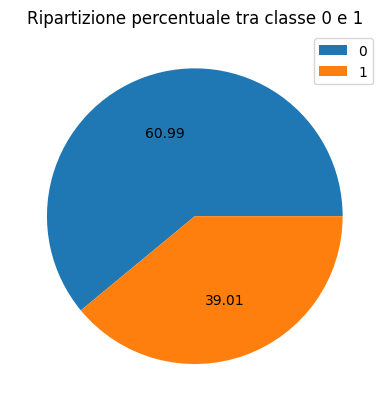

In [15]:
print(f'''Numero di campioni classe 0: {df["ph"][df["Potability"]==0].count()}

Numero di campioni classe 1: {df["ph"][df["Potability"]==1].count()}''')

plt.pie(x=df.groupby('Potability')['Potability'].value_counts(), autopct='%.2f')
plt.legend(['0','1'])
plt.title('Ripartizione percentuale tra classe 0 e 1')

Per bilanciare le due classi utilizzeremo una tecnica chiamata **SMOTE** (Synthethic Minority Oversampling Technique).  
In sostanza creeremo dei nuovi campioni della classe 1 a partire da quelli già esistenti finché il rapporto tra classe 0 e classe 1 non sarà 50:50.  
Per creare i nuovi campioni, verranno selezionati *n* campioni casuali di classe 1 e verrà assegnato un randomico rapporto di proporzione tra loro, che determinerà i valori delle feature del nuovo campione

Text(0.5, 1.0, 'Ripartizione percentuale tra classe 0 e 1')

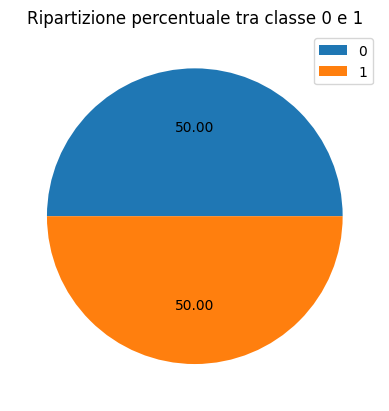

In [16]:
sm = SMOTE(sampling_strategy='minority', random_state=42) #solamente la classe minoritaria sarà soggetta all'algoritmo

X, y = sm.fit_resample(X=df.drop(columns='Potability'), 
                      y=df['Potability'])

plt.pie(x=y.value_counts(), autopct='%.2f')
plt.legend(['0','1'])
plt.title('Ripartizione percentuale tra classe 0 e 1')

Ora le classi sono perfettamente bilanciate

### Separazione in training set e test set

Separiamo i dati appena ottenuti per avere un training set e un test set in rapporto 2:1.  
Utilizzeremo lo *stratified sampling*, per assicurarci che la frequenza di campioni di classe 0 e 1 sia sempre rispettata sia nel training set che nel test set. In questo modo, si evita che le classi si sbilancino di nuovo, portando a probabili errori. 

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
print(f'''X_train shape: {X_train.shape} 
X_test shape: {X_test.shape}
y_train shape: {y_train.shape} di cui appartenenti alla classe 0: {y_train.value_counts()[0]}
y_test shape: {y_test.shape} di cui appartenenti alla classe 0: {y_test.value_counts()[0]}''') 

X_train shape: (2677, 9) 
X_test shape: (1319, 9)
y_train shape: (2677,) di cui appartenenti alla classe 0: 1338
y_test shape: (1319,) di cui appartenenti alla classe 0: 660


### Correlazione tra variabili

Costruiamo una matrice di correlazione per verificare che ci siano delle relazioni tra variabili:

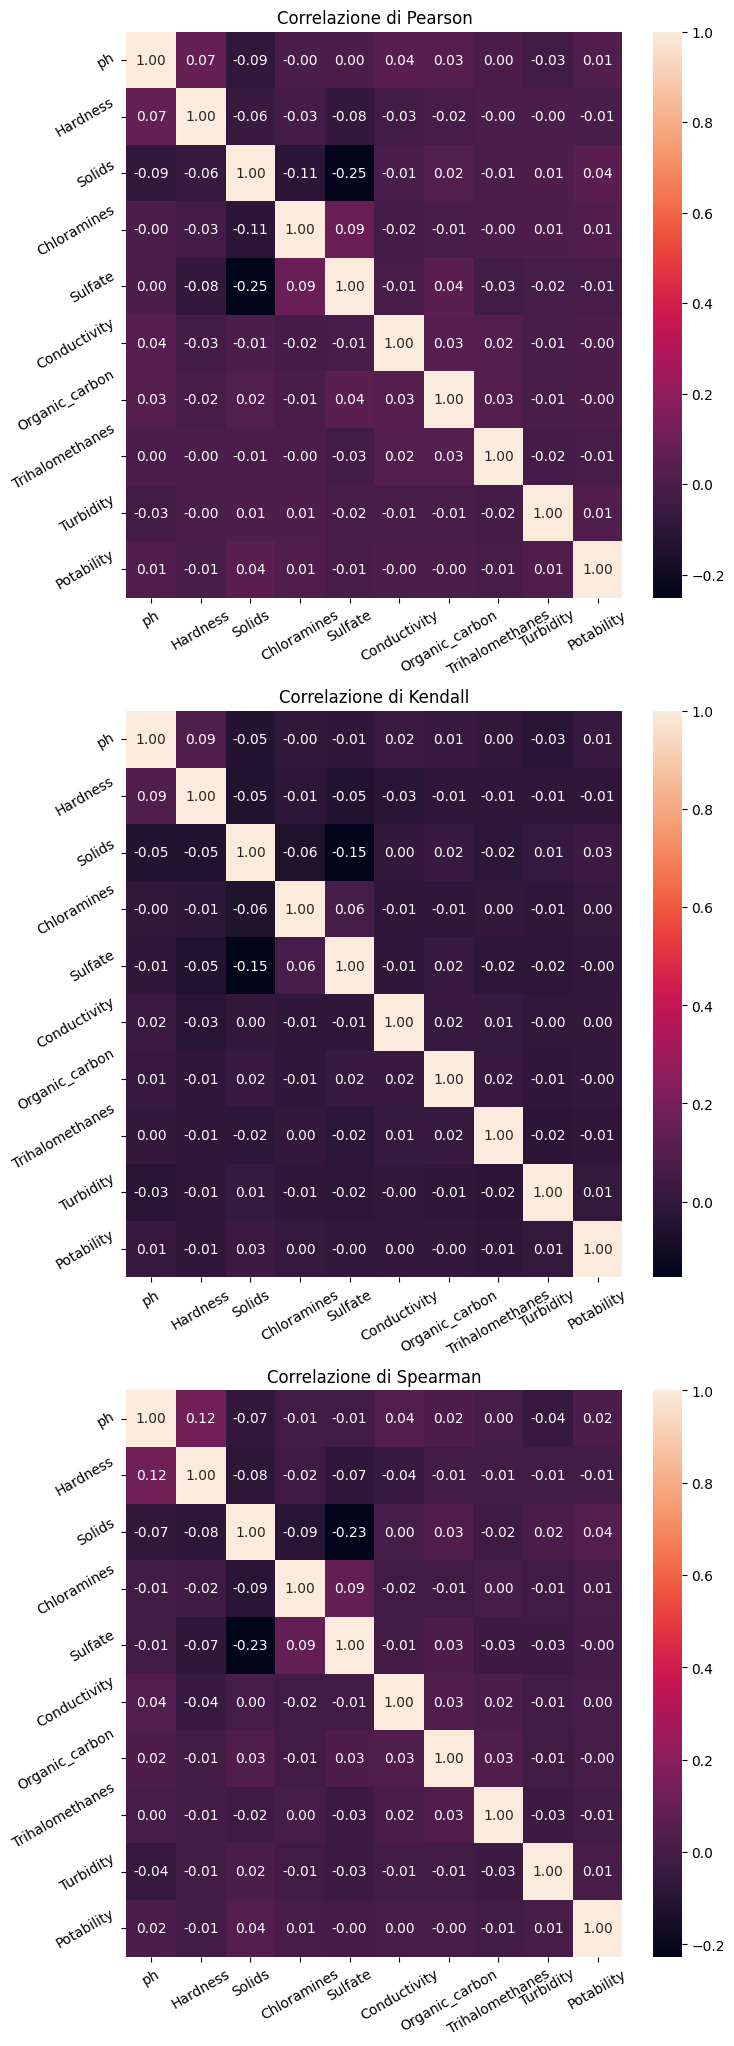

In [18]:
fig, ax = plt.subplots(nrows=3, figsize=(8,25))

sns.heatmap(pd.concat([X_train, y_train], axis=1).corr(), annot=True, fmt=".2f", ax=ax[0])
ax[0].set_title('Correlazione di Pearson')
ax[0].tick_params(labelrotation=30)
sns.heatmap(pd.concat([X_train, y_train], axis=1).corr(method='kendall'), annot=True, fmt=".2f", ax=ax[1])
ax[1].set_title('Correlazione di Kendall')
ax[1].tick_params(labelrotation=30)
sns.heatmap(pd.concat([X_train, y_train], axis=1).corr(method='spearman'), annot=True, fmt=".2f", ax=ax[2])
ax[2].set_title('Correlazione di Spearman')
ax[2].tick_params(labelrotation=30)

Sono state realizzate le matrici di correlazione con tre metriche diverse (*Pearson, Kendall e Spearman*) per captare anche eventuali relazioni non lineari tra le variabili, ma in nessuno dei casi sembra esserci nulla di significativo (tranne per una leggera correlazione negativa tra i solidi e i solfati, che però può essere ignorata).

Anche visivamente si può verificare che le variabili non abbiano delle relazioni tra di loro, e che quella tra solidi e solfati è dovuta a pochi campioni agli angoli che probabilmente sono allineati per caso. 

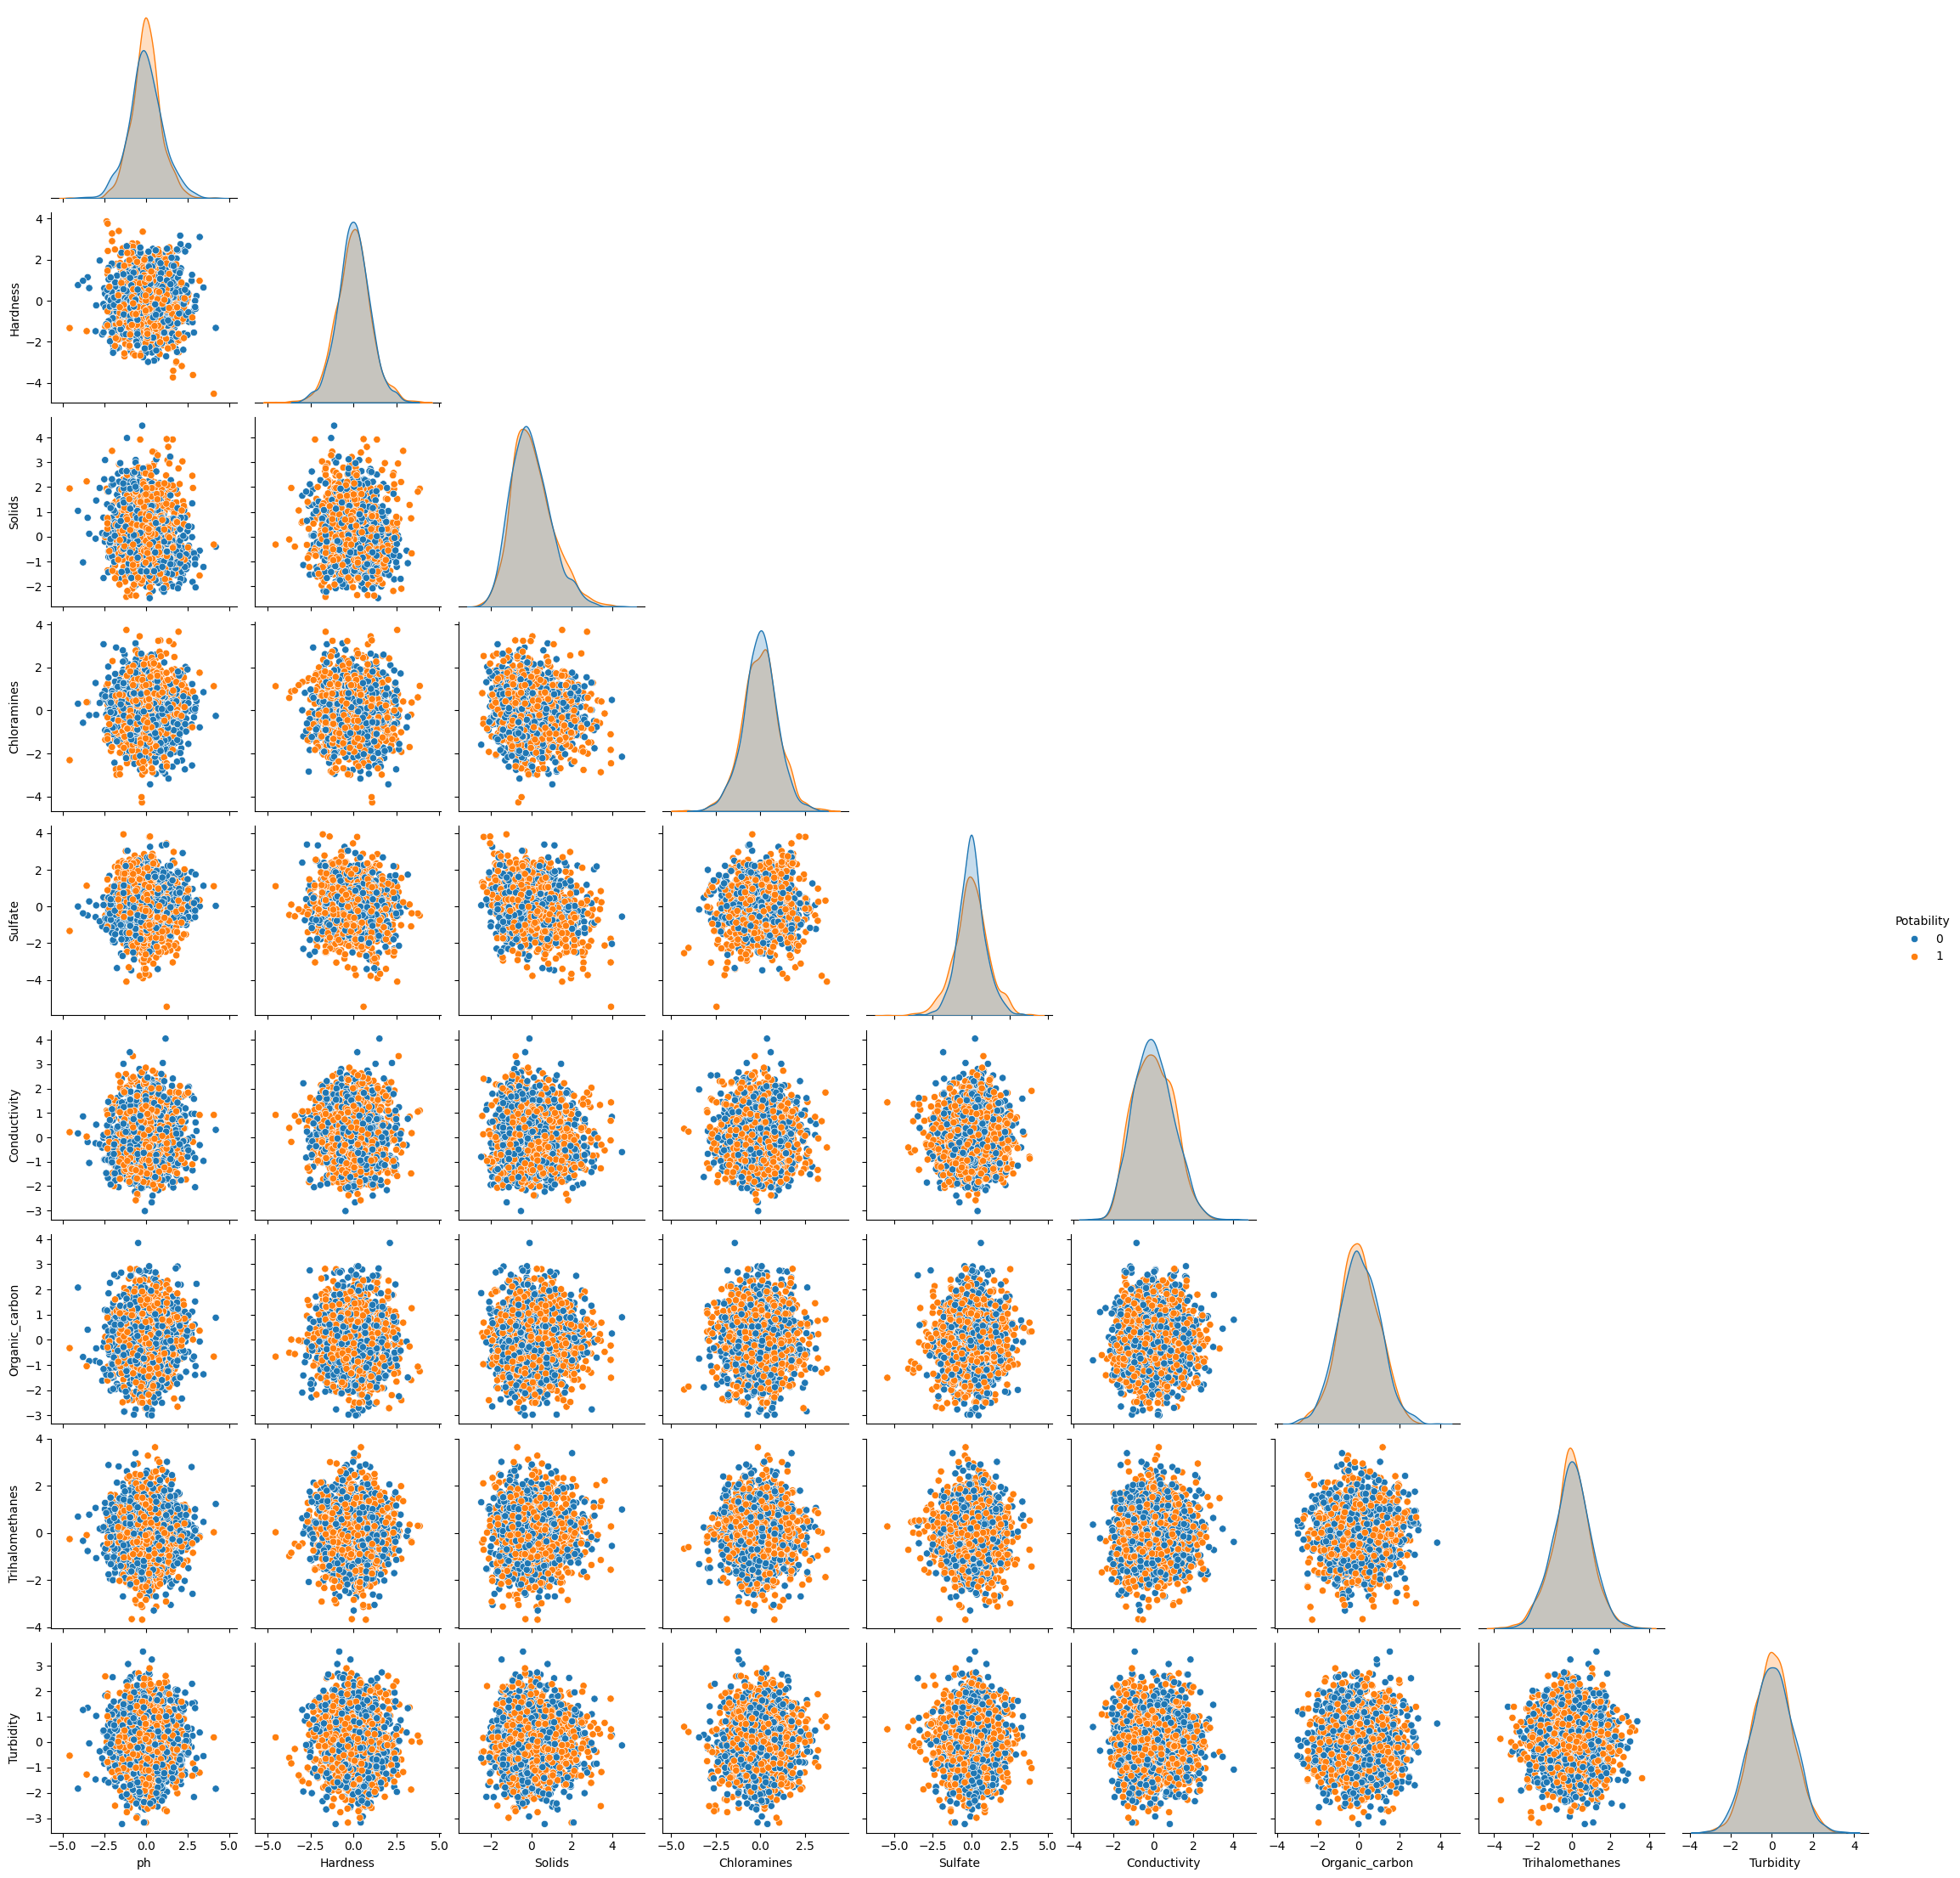

In [19]:
sns.pairplot(pd.concat([X_train,y_train], axis=1), hue='Potability', corner=True)

### Significatività delle variabili

Per comprendere se ci sono delle variabili che hanno una maggiore importanza nel distinguere i campioni tra classe 0 e 1, possiamo operare dei processi di **feature selection**.  
Avendo a che fare solamente con variabili numeriche continue non sarà possibile svolgere il Test Chi-Square. 

Si potrebbe fare un'analisi della varianza di ogni feature per poter eliminare quelle con varianza inferiore: se infatti una variabile cambia poco di valore, probabilmente non sarà in grado di predire bene il target

In [20]:
X_train.var()

ph                 0.923360
Hardness           0.947063
Solids             1.001907
Chloramines        0.981373
Sulfate            1.026926
Conductivity       0.973401
Organic_carbon     0.961498
Trihalomethanes    0.958618
Turbidity          0.967541
dtype: float64

Le varianze sono praticamente le stesse per tutte le feature, per cui non è possibile procedere in questo modo. 

Potremmo dunque utilizzare la *mutual information* per assegnare uno score a ogni singola variabile e prendere solamente le *k* con score più alto.  
Come i coefficienti di correlazione, lo score di mutual information può dirci quanto il variare di una feature fa variare anche il target e, quindi, quanto bene riesce a predirlo.  

In [21]:
scores = pd.concat([
    pd.DataFrame(X_train.columns), #la prima colonna del dataframe sarà il nome delle variabili
    pd.DataFrame(mutual_info_classif(X_train, y_train, random_state=42)), #lanciamo la funzione per trovare la mutual information tra ogni feature e la y
], axis=1)

scores.columns = ['Feature', 'Score'] #Rinominiamo le colonne

scores

,Feature,Score
0,ph,0.025930
1,Hardness,0.005341
2,Solids,0.000000
3,Chloramines,0.000000
4,Sulfate,0.026185
5,Conductivity,0.000191
6,Organic_carbon,0.008836
7,Trihalomethanes,0.000000
8,Turbidity,0.000404


Notiamo che ci sono alcune feature a zero, per cui non hanno nessun tipo di impatto sulla predizione del target.  
Altre (*Hardness*, *Conductivity*, *Turbidity*) sono approssimabili a zero. 
Possiamo creare una copia sia dal training che dal test set in cui tutte queste variabili non sono presenti, per poi valutare i modelli con entrambe le casistiche e decidere quale opzione sia meglio. 

In [22]:
X_train_selected = X_train.drop(columns=['Solids', 'Chloramines', 'Trihalomethanes', 'Hardness', 'Conductivity', 'Turbidity'])
X_test_selected = X_test.drop(columns=['Solids', 'Chloramines', 'Trihalomethanes', 'Hardness', 'Conductivity', 'Turbidity'])

# Analisi

### Scelta della metrica

Per questo progetto verrà usata l'**accuracy** come metrica di riferimento per tutti i modelli che verranno realizzati.  
Non è tuttavia l'unica disponibile e ne vanno considerate anche altre, tra cui:
- ***Precision***. Misura il numero di campioni correttamente etichettati 1 diviso il numero totale di campioni che sono stati etichettati 1 <span style="font-size:20px">$\frac{TP}{TP+FP}$ </span>
- ***Recall***. Misura il numero di campioni correttamente etichettati 1 diviso il numero totale di campioni che sono realmente 1 <span style="font-size:20px"> $\frac{TP}{TP+FN}$ </span>
- ***F1-Score***. Sintetizza Precision e Recall facendo una loro media armonica <span style="font-size:20px"> $\frac{2}{\frac{1}{Precision}+\frac{1}{Recall}}$ </span>
- ***Jaccard Index***. Misura la similarità tra y_test e le predizioni secondo la seguente formula <span style="font-size:20px"> $\frac{\lvert Y\cap\hat{Y}\rvert}{\lvert Y\cup\hat{Y}\rvert}$ </span>

### Spot checking

Attraverso lo *spot checking* è possibile capire quale modello tra quelli utilizzati performi meglio su questo dataset.  
Per farlo, utilizzeremo:
- Regressione Logistica
- Random Forest
- K-nearest Neighbors  

Tutti e tre verranno valutati in base alla loro *accuracy* mostrata sul training set.  
Per quanto riguarda la scelta delle features, utilizzeremo sia l'intero training set che le features selezionate nel paragrafo "Significatività delle variabili".  
Per la validazione utilizzeremo anche **Strafified K-Fold Cross-Validation** messo a disposizione da Scikit-learn: verrà impiegato l'intero training che, di volta in volta, verrà suddiviso in modo diverso tra training e validation set. 

Anziché ripetere per 6 volte lo stesso codice, definiamo una funzione che ritorni l'accuracy media di ogni modello dopo che è stata fatta la cross-validazione:

In [23]:
def get_score(model, X_train, y_train, n_splits=10, shuffle=True, random_state=42):
    #lista per memorizzare i punteggi di ogni fold
    scores_accuracy = []

    #
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)
    
    #iterazione su ogni fold
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_cross, X_test_cross = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cross, y_test_cross = y_train.iloc[train_index], y_train.iloc[test_index]
        
        model.fit(X_train_cross, y_train_cross)
        
        pred = model.predict(X_test_cross)
        
        #calcoliamo e salviamo le metriche
        scores_accuracy.append(accuracy_score(y_test_cross, pred))
    
    #calcoliamo la media delle accuracy
    avg_accuracy = sum(scores_accuracy) / len(scores_accuracy)
    return avg_accuracy

Ora calcoliamo tutte le metriche necessarie per confrontare i modelli:

In [24]:
#inizializziamo i modelli per inserirli nella funzione
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()

print(f''' SCORE COMPLESSIVI

Linear Regression:  {get_score(lr, X_train, y_train)}
Linear Regression con features selezionate: {get_score(lr, X_train_selected, y_train)}

Random Forest : {get_score(rf, X_train, y_train)}
Random Forest con features selezionate: {get_score(rf, X_train_selected, y_train)}

KNN: {get_score(knn, X_train, y_train)}
KNN con features selezionate: {get_score(knn, X_train_selected, y_train)}
''')

 SCORE COMPLESSIVI

Linear Regression:  0.4987031136452568
Linear Regression con features selezionate: 0.505036614679412

Random Forest : 0.7078400134160656
Random Forest con features selezionate: 0.5920761361730672

KNN: 0.6417267594611215
KNN con features selezionate: 0.5827296103750909



I due migliori modelli sono **Random Forest** e **KNN**, entrambi con l'intero dataset anziché le sole features selezionate.  

### Tuning

In questa fase utilizzeremo solamente i due modelli migliori risultanti dallo spot-checking.  
L'obiettivo è quello di trovare i parametri migliori da impiegare per predire i dati contenuti nel test set. Per farlo, utilizzeremo **GridSearchCV**.

#### Random Forest

I parametri da ottimizzare sono i seguenti:
- *n_estimator*. Il numero di decision trees presenti nella foresta
- *max_features*. Il numero massimo di feature da considerare per splittare un nodo
- *max_depth*. La profondità massima che ogni albero può raggiungere
- *min_samples_split*. Il numero minimo di campioni per svolgere uno split del nodo
- *min_samples_leaf*. Numero minimo di campioni permessi in una foglia

<span style="font-size:20px">***N.B.:***</span> la cella dove è stata svolta l'ottimizzazione con GridSearch è stata convertita in markdown perché richiede molto tempo per essere eseguita, e pertanto crea problemi ogni volta che si vuole riavviare il kernel.  
Il modello ha trovato questi parametri: 

<img src="Best_scores_rf.png">

Normalmente si potrebbe fare la predizione direttamente dalla GridSearch, ma in questo caso al primo riavvio la funzione GridSearch non comparirebbe più nel notebook.  
Pertanto, ricostruiremo un normale modello di RandomForest utilizzando i parametri trovati. 

<span style="background-color:#1c87c9"> \# lista dei parametri da ottimizzare, con valori creati grazie alla funzione arange di numpy
parameters_rf = {'n_estimators': np.arange(90, 110, 10),
                 'max_features': np.arange(6, 9, 1),
                 'max_depth': np.arange(5, 8, 1),
                'min_samples_split': np.arange(1, 4, 1),
                'min_samples_leaf': np.arange(1, 4, 1)}
#inizializzazione della GridSearch
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=parameters_rf,
    cv=5,
    n_jobs=-1 #utilizziamo contemporaneamente tutti i core del processore per velocizzare il processo
)
grid_rf.fit(X_train, y_train)
grid_rf.best_params_ </span>

In [25]:
rf = RandomForestClassifier(n_estimators=100, max_depth=7, max_features=6, min_samples_leaf=3, min_samples_split=3).fit(X_train, y_train)

pred_rf = rf.predict(X_test)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, pred_rf)))

Accuracy: 0.65


L'accuracy mostrata sul training set era maggiore (0.69) ma questo è normale, perché il test set contiene campioni che il modello non ha mai visto prima. 

#### KNN

In questo caso, i parametri da ottimizzare sono:
- *n_neighbors*. Il numero di campioni 'vicini' da considerare per classificare un nuovo sample
- *weights*. Il peso da assegnare a ciascun campione vicino nella classificazione

Come prima, impostiamo una GridSearch, fittiamola con i dati e estrapoliamo i migliori parametri:

In [26]:
knn = KNeighborsClassifier()
parameters_knn = {'n_neighbors': np.arange(1, 7, 1),
                 'weights': ['uniform', 'distance']}

grid_knn = GridSearchCV(
    estimator=knn,
    param_grid=parameters_knn,
    cv=5,
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)

grid_knn.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

Svolgiamo la predizione sul test data e stampiamo l'accuracy risultante

In [27]:
pred_knn = grid_knn.predict(X_test)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, pred_knn)))

Accuracy: 0.71


# Conclusioni

Ci siamo trovati di fronte a un problema di classificazione binaria: l'acqua è potabile (1) oppure no (0). L'obiettivo è stato quello di trovare il modello che meglio predicesse la potabilità sulla base delle 9 features contenute all'interno del dataset.  
Dopo aver pulito i dati e analizzato la loro distribuzione e correlazione, abbiamo cercato le 3 features che meglio potessero descrivere la potabilità dell'acqua attraverso il calcolo della *mutual information*, in grado di intercettare anche relazioni non lineari o polinomiali.  
Fatto ciò, abbiamo analizzato le performance di tre modelli (Logistic Regression, Random Forest e K-Nearest Neighbors), fittando l'intero training set oppure solamente le 3 features selezionate. Sorprendentemente, i modelli migliori si sono rivelati essere quelli che consideravano l'intero dataset: probabilmente vi erano alcune interazioni tra le features che producevano dell'informazione che la feature selection non ha afferrato.  
Avendo selezionato i modelli di Random Forest e K-Nearest Neighbors come i migliori, abbiamo proseguito con l'ottimizzazione degli iperparametri attraverso GridSearch. Facendo ciò, si è visto che il modello in assoluto più performante è il KNN, con un'accuracy sul test set di circa il 71%.